In [1]:
from dask.distributed import Client
import multiprocessing

ncpu = multiprocessing.cpu_count()
nworker = 8
threads = ncpu // nworker
print(ncpu, threads, nworker)

client = Client(
    processes=False, threads_per_worker=threads, n_workers=nworker, memory_limit="64GB"
)
client

72 9 8


Client Scheduler: inproc://10.50.47.48/40151/1 Dashboard: http://localhost:8888/proxy/8787/status,Cluster Workers: 8 Cores: 72 Memory: 512.00 GB


In [1]:
%load_ext lab_black

In [2]:
import xarray as xr

xr.set_options(keep_attrs=True)
import os
import dask
import numpy as np
import pandas as pd
import warnings

warnings.simplefilter("ignore")

from tqdm.notebook import tqdm
import xskillscore as xs
import regionmask
import geopandas

In [3]:
# plotting options
import matplotlib.pyplot as plt
import matplotlib as mpl
import cmocean
import seaborn as sns

%matplotlib inline
mpl.rcParams["savefig.dpi"] = 300
mpl.rcParams["savefig.pad_inches"] = 0
mpl.rcParams["savefig.format"] = "eps"
savefig = False
sns.set_context("notebook")
# mpl.rcParams

## load custom functions

In [56]:
# post
from basics import to_zarr, load_var_cdo, output_df2, output_df

# paths
from basics import (
    c,
    outpath,
    exppath,
    postpath,
    atmvarlist,
    oceanvarlist,
    ocean_zarr,
    pocean_zarr,
    atm_zarr,
    patm_zarr,
)

# runs
from basics import direct_run, indirect_run, run_dict

# area
from basics import ocean_area, land_area, global_agg, yearmean, var_area

# metadata
from basics import (
    latexify_units,
    add_showname,
    convert_C,
    kgC_s_to_PgC_month,
    metric_longname,
)

# plot
from basics import add_figurelabels, c_dict

# misc
from basics import clean

In [5]:
sns.set_palette(
    sns.color_palette([c_dict["perfect"], c_dict["indirect"], c_dict["direct"]])
)

In [6]:
v = "spco2"  # ,"box_Cpools_total"  # "co2_flux"

# postprocess output to `zarr`

In [7]:
init_dates = np.arange(1860, 1897, 2)
init_dates

array([1860, 1862, 1864, 1866, 1868, 1870, 1872, 1874, 1876, 1878, 1880,
       1882, 1884, 1886, 1888, 1890, 1892, 1894, 1896])

In [8]:
members = np.arange(5)
members

array([0, 1, 2, 3, 4])

## aggregate `netcdf`s

In [9]:
######### CHANGED TO ATMTSI3 and ATMTSIDICALKlandralls ##############
# init_types = ["vga0220a_Rerun", "ATMTSI", "ATMTSIDICALKlandrall"]
init_types = ["vga0220a_Rerun", "ATMTSI3", "ATMTSIDICALKlandralls"]
init_types_labels = ["perfect", "indirect", "direct"]

In [10]:
def get_control(v=v, init_dates=init_dates):
    if output_df2.loc[v]["model"] in ["echam6", "jsbach"]:
        ds = xr.open_zarr(atm_zarr)[v].sel(run=c, drop=True)
    else:
        ds = xr.open_zarr(ocean_zarr)[v].sel(run=c, drop=True)
    ds_list = []
    for init_date in init_dates:
        t = ds.sel(time=slice(str(init_date), str(init_date + 2)))
        t["time"] = np.arange(1, 1 + t.time.size)
        ds_list.append(t)
    ds_c = xr.concat(ds_list, "init", **CONCAT_KWARGS)
    ds_c["init"] = init_dates
    return ds_c.rename({"time": "lead"})


#%time ds_c = get_control().compute()

In [11]:
from climpred.constants import CONCAT_KWARGS


def process_var(v=v, init_dates=init_dates, init_type=init_types, members=members):
    sel = "" if v != "CO2" else ",levidx=47"

    init_date_ds_list = []
    for init_date in tqdm(init_dates):
        init_types_ds_list = []
        for init_type in init_types:
            members_ds_list = []
            for member in members:
                expid = f"asp_PMassim_recon{init_type}_init{init_date}_m00{member}"
                # print(v,expid,member)
                ds = load_var_cdo(
                    exppath=exppath, var=v, expid=expid, sel=sel, output_df=output_df2,
                )[v].squeeze()
                ds["time"] = np.arange(1, 1 + ds.time.size)
                members_ds_list.append(ds)
            members_ds = xr.concat(members_ds_list, "member", **CONCAT_KWARGS)
            init_types_ds_list.append(members_ds)
        init_date_ds = xr.concat(init_types_ds_list, dim="init_type", **CONCAT_KWARGS)
        init_date_ds_list.append(init_date_ds)

    ds = xr.concat(init_date_ds_list, "init", **CONCAT_KWARGS)
    ds["init_type"] = init_types_labels
    ds["init"] = init_dates
    ds["member"] = np.arange(1, 1 + len(members))
    ds = clean(ds)
    ds = ds.rename({"time": "lead"})

    # print('get_control')
    ds_c = get_control(v=v, init_dates=init_dates)
    ds_c = ds_c.expand_dims("member")
    ds_c["member"] = [0]

    if "lon" in ds.dims:
        ds_c["lat"] = ds.lat
    ds_init = xr.concat([ds_c, ds], dim="member")
    ds_init["member"] = np.arange(ds.member.size + 1)
    return ds_init

In [12]:
check = False
if check:
    v = "spco2"
    #%time init = process_var(v=v)
    # init = init.to_dataset(name=v)

    a = ocean_area
    # global_agg(init,area=a).isnull().any().compute()
    # alternative: load from zarr
    init = xr.open_zarr(pocean_zarr)[[v]]
    global_agg(init, area=a).map(yearmean, dim="lead")[v].isel(
        lead=slice(None, 2)
    ).plot(hue="init_type", row="init", col="member")

## save to zarr

In [13]:
# many variables from all runs

In [14]:
!ls /work/mh0727/m300524/191008_PM_assim/post/

atm_bu.zarr  ocean_bu.zarr  pred_atm_bu.zarr  pred_ocean_bu.zarr
atm.zarr     ocean.zarr     pred_atm.zarr     pred_ocean.zarr


In [15]:
# delete if needed
import shutil

# shutil.rmtree(patm_zarr)
# shutil.rmtree(pocean_zarr)

In [16]:
#%time to_zarr(atmvarlist, name="pred_atm",process_var=process_var)

In [17]:
#%time to_zarr(oceanvarlist, name="pred_ocean",process_var=process_var)

In [18]:
# quick check
# sns.set_palette('Set2')
# yearmean(xr.open_zarr(pocean_zarr)['tos'].mean(['x','y','member']), dim='lead').plot(hue='init_type',col='init',col_wrap=5)

# globally aggregated (Spring 2021 Fig.3)

In [19]:
land_area2 = land_area.copy()
land_area2["lat"] = xr.open_zarr(patm_zarr).lat

In [20]:
from climpred import PerfectModelEnsemble

In [21]:
v = "spco2"

In [22]:
init_type_labels = ["perfect", "indirect", "direct"]

In [24]:
%%time
inits = convert_C(xr.open_zarr(pocean_zarr)[['spco2','fgco2']]).map(global_agg,area=ocean_area)

inits = inits.update(
    convert_C(xr.open_zarr(patm_zarr)[["box_Cpools_total", "co2_flx_land", "CO2"]]).map(
        global_agg, area=land_area
    )
).compute()

In [25]:
# inits = inits.sel(init_type=init_type_labels)
# del inits.coords['run']

In [26]:
init_types_runnames = ["vga0220a_Rerun", "ATMTSI", "ATMTSIDICALKlandr"]

In [27]:
%%time
controls = convert_C(xr.open_zarr(ocean_zarr).sel(run=init_types_runnames)[['spco2','fgco2']]).map(global_agg,area=ocean_area)
controls = controls.update(convert_C(xr.open_zarr(atm_zarr).sel(run=init_types_runnames)[['box_Cpools_total','co2_flx_land','CO2']]).map(global_agg,area=land_area)).compute()

converted spco2 from Pa to ppm
converted CO2 from kg kg-1 to ppm
converted co2_flx_land from CO2 units to C units.
converted box_Cpools_total from mol(CO2) to kgC
CPU times: user 5.59 s, sys: 6.88 s, total: 12.5 s
Wall time: 9.09 s


In [28]:
inits = inits.map(kgC_s_to_PgC_month)
controls = controls.map(kgC_s_to_PgC_month)

converted Surface downward mass flux of carbon dioxide expressed as carbon
converted total upward land C flux (acc.)
converted Surface downward mass flux of carbon dioxide expressed as carbon
converted total upward land C flux (acc.)


In [62]:
# save intermediate results
inits.to_netcdf("inits.nc")
controls.to_netcdf("controls.nc")

In [94]:
!pwd

/mnt/lustre01/pf/zmaw/m300524/PhD_Thesis/PhD_scripts/191008_PM_assim


In [29]:
# inits_ym=inits.map(yearmean,dim='lead')
# controls_ym=controls.map(yearmean,dim='time')
inits.lead.attrs["units"] = "years"

if inits.lead.attrs["units"] != "months":
    print("set year lead")
    inits_ym = inits.map(yearmean, dim="lead")
    inits_ym.lead.attrs["units"] = "years"
    controls_ym = controls.map(yearmean)
    inits_ym["init"] = xr.cftime_range(
        start="1859", freq="2YS", periods=inits_ym.init.size
    )
    controls_ym["time"] = xr.cftime_range(
        start="1850", freq="YS", periods=controls_ym.time.size
    )
else:  #'months'
    inits["init"] = xr.cftime_range(
        start="1859-12-01", freq="24MS", periods=inits.init.size
    )
    controls["time"] = xr.cftime_range(
        start="1850", freq="MS", periods=controls.time.size
    )

set year lead


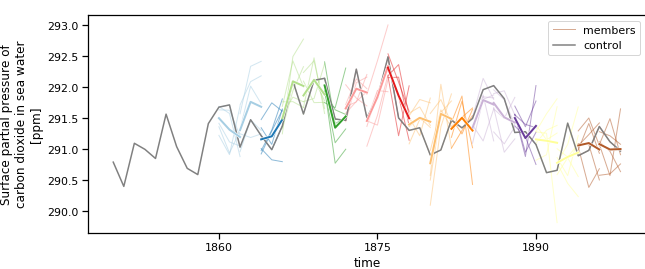

In [30]:
# climpred quick ensemble plot
init_type = "perfect"
if inits.lead.attrs["units"] == "years":
    PerfectModelEnsemble(inits_ym.sel(init_type=init_type)).add_control(
        controls_ym.sel(run=c)
    )[v].plot(show_members=True, cmap="Paired")
else:
    PerfectModelEnsemble(inits.sel(init_type=init_type)).add_control(
        controls.sel(run=c)
    )[v].plot(show_members=True, cmap="Paired")

In [38]:
def plot_timeseries(inits_ym, ax=None, stride=2):
    if not ax:
        fig, ax = plt.subplots(figsize=(15, 3))
    v = inits_ym.name
    controls_ym[v].sel(run=c).plot(ax=ax, c=c_dict["perfect"], ls="-", label="perfect")
    controls_ym[v].sel(run=indirect_run).plot(
        ax=ax, c=c_dict["indirect"], ls="-", label="indirect"
    )
    controls_ym[v].sel(run=direct_run).plot(
        ax=ax, c=c_dict["direct"], ls="-", label="direct"
    )

    p = (
        inits_ym.sel(init=slice(None, None, stride))
        .drop_sel(member=0)
        .rename({"lead": "time"})
    )

    for j in p.init_type:
        j = str(j.values)
        for ii, i in enumerate(p.init):
            pp = p.sel(init=i, init_type=j, drop=True)
            ppp = xr.concat(
                [
                    controls_ym[v].sel(run=run_dict[j], time=str(int(i.init.dt.year))),
                    pp,
                ],
                dim="time",
            )
            ppp["time"] = xr.cftime_range(
                start=str(int(i.init.dt.year)), freq="YS", periods=pp.time.size + 1
            )
            ppp.plot(
                ax=ax,
                hue="member",
                ls="--",
                add_legend=False,
                color=c_dict[j],
                alpha=0.3,
            )
            ppp.mean("member").plot(
                ax=ax, ls="--", add_legend=False, color=c_dict[j], alpha=0.7
            )
    # ax.set_title(f'{v}')
    # ax.set_xlim([1860,1899])
    ax.legend(title="reconstruction", loc="lower left")
    # add more variables


# plot_timeseries(inits_ym[v])

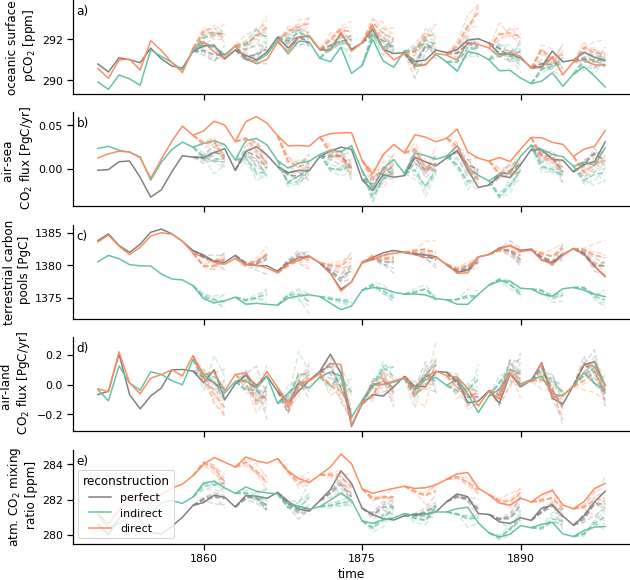

In [39]:
sns.set_context("notebook")
nv = len(list(inits_ym.data_vars))
fig, ax = plt.subplots(figsize=(2 * nv, 2 * nv), nrows=nv, sharex=True)
for i, vv in enumerate(inits_ym.data_vars):
    plot_timeseries(inits_ym[vv], ax=ax[i])
    if i != nv - 1:
        ax[i].get_legend().remove()
        ax[i].set_xlabel("")
    ax[i].set_title("")

ax[0].set_ylabel("oceanic surface\n pCO$_2$ [ppm]")
ax[1].set_ylabel("air-sea \n CO$_2$ flux [PgC/yr]")
ax[2].set_ylabel("terrestrial carbon\n pools [PgC]")
ax[3].set_ylabel("air-land \n CO$_2$ flux [PgC/yr]")
ax[4].set_ylabel("atm. CO$_2$ mixing\n ratio [ppm]")

add_figurelabels(ax)

# plt.xlim([1850, 1898])
# plt.xticks(np.arange(1850,1900,10))
sns.despine()
plt.savefig(
    f"PM_assim_initialized_timeseries_carbon.png",
    transparent=True,
    bbox_inches="tight",
    pad_inches=0,
)

In [33]:
# inits_ym[v].mean('member').plot(hue='init_type',col='init',col_wrap=5)

# predictability

In [40]:
import climpred

climpred.__version__

from climpred import PerfectModelEnsemble

In [41]:
# monthly spatial aggregated
pmms = PerfectModelEnsemble(inits)

In [42]:
# yearly spatial aggregated
pmys = pmms.map(yearmean, dim="lead")

In [61]:
metric = "rmse"
dim = ["member", "init"]
comparison = "m2c"

cp_kwargs = {"dim": dim, "comparison": comparison, "keep_attrs": True}

## skill

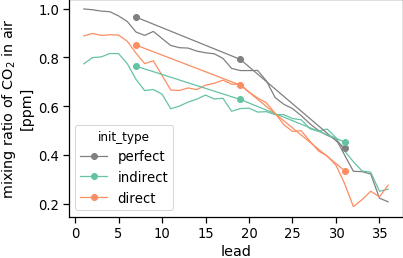

In [60]:
skill = pmms.verify(metric=metric, **cp_kwargs)
skill[v].plot(hue="init_type")
pmys.verify(metric=metric, **cp_kwargs)[v].assign_coords(
    lead=[7 + 12 * i for i in range(3)]
).plot(hue="init_type", marker="o")

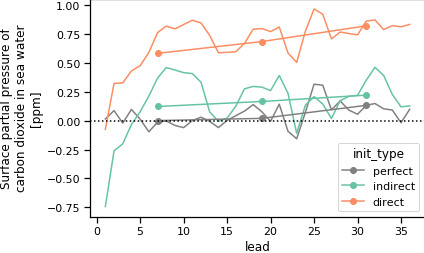

In [45]:
bias = pmms.verify(metric="bias", **cp_kwargs)
bias_ym = pmys.verify(metric="bias", **cp_kwargs)
bias[v].plot(hue="init_type")
bias_ym[v].assign_coords(lead=[7 + 12 * i for i in range(3)]).plot(
    hue="init_type", marker="o"
)
plt.axhline(y=0, ls=":", c="k")

## remove bias

In [46]:
def attach_attrs(new, old):
    if (isinstance(new, xr.DataArray) and isinstance(old, xr.Dataset)) or (
        isinstance(old, xr.DataArray) and isinstance(new, xr.Dataset)
    ):
        raise ValueError("require same types")
    if isinstance(new, xr.DataArray):
        new.attrs = old.attrs
    else:
        for v in new.data_vars:
            new[v].attrs = old[v].attrs
    return new


def debias(ds_inits, bias):
    ds_debiased = xr.concat(
        [ds_inits.sel(member=[0]), ds_inits.drop_sel(member=0) - bias], "member"
    )
    ds_debiased = attach_attrs(ds_debiased, ds_inits)
    return ds_debiased


inits_debiased = debias(inits, bias)
inits_ym_debiased = debias(inits_ym, bias_ym)

In [47]:
inits_ym2 = xr.concat([inits_ym, inits_ym_debiased], "debiased")
inits_ym2["debiased"] = [False, True]
inits2 = xr.concat([inits, inits_debiased], "debiased")
inits2["debiased"] = inits_ym2["debiased"]

In [48]:
# debiased monthly spatial aggregated
# pmmsd = PerfectModelEnsemble(inits_debiased)

# skill = pmmsd.verify(metric=metric, **cp_kwargs)
# skill[v].plot(hue='init_type')
##pmysd.verify(metric=metric, **cp_kwargs)[v].assign_coords(lead=[7+12*i for i in range(3)]).plot(hue='init_type',marker='o')

## bootstrap init

In [49]:
# biased and debiased yearly spatial aggregated
pmysd = PerfectModelEnsemble(inits_ym2)

from climpred.bootstrap import _resample_iterations_idx

iterations = 500
d = _resample_iterations_idx(pmysd.get_initialized(), iterations=iterations, dim="init")
d["lead"].attrs["units"] = "years"
d = attach_attrs(d, pmysd.get_initialized())

pmysdr = PerfectModelEnsemble(d)

skillysdr = pmysdr.verify(metric=metric, **cp_kwargs)

In [50]:
# do somewhere above?
skillysdr = skillysdr.map(latexify_units)
skillysdr = skillysdr.map(add_showname)

In [51]:
# get in data into long format: https://seaborn.pydata.org/tutorial/data_structure.html#long-form-vs-wide-form-data
df = skillysdr.to_dataframe()

df2 = df.unstack(level=0).unstack(level=0).unstack().melt()

df2.columns = ["variable", "debiased", "initialization", "lead", metric]

## bootstrap uninit

In [52]:
from climpred.bootstrap import _bootstrap_by_stacking

uninit = xr.concat(
    [
        _bootstrap_by_stacking(
            pmysd.get_initialized()
            .drop_sel(member=0)
            .isel(debiased=0, drop=True, init_type=0),
            controls_ym.sel(run=c),
        )
        for i in range(iterations)
    ],
    "iteration",
)

# add control member 0
uninit = xr.concat(
    [
        pmysd.get_initialized()
        .sel(member=[0])
        .isel(debiased=0, drop=True, init_type=0),
        uninit,
    ],
    dim="member",
)

pm_unint = PerfectModelEnsemble(uninit)

uninit_skill = pm_unint.verify(metric=metric, **cp_kwargs)
uninit_skill_mean = uninit_skill.mean("iteration").mean("lead")
uninit_skill_std = uninit_skill.std("iteration").mean("lead")

## plot (Spring 2021 Fig. 7)

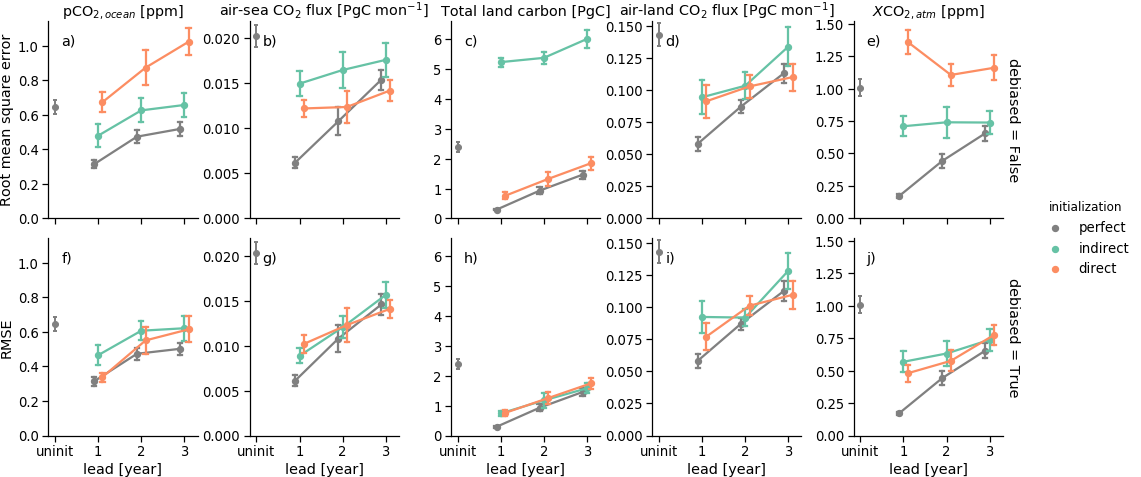

In [58]:
sns.set_context("notebook", font_scale=1.2, rc={"lines.linewidth": 1.25})
mpl.rcParams[
    "legend.loc"
] = "lower left"  # todo: get legend elsewhere, or legend_out=True

g = sns.catplot(
    data=df2,
    kind="point",
    sharex=True,
    sharey="col",
    margin_titles=True,
    x="lead",
    y=metric,
    hue="initialization",
    col="variable",
    row="debiased",
    legend_out=True,
    hue_order=["perfect", "indirect", "direct"],
    dodge=0.2,
    capsize=0.1,
    ci="sd",
    height=3.5,
    aspect=0.85,  # change figsize
)

# g.set_ylabels('Mean Absolute Error (MAE)')
g.axes[1][0].set_ylabel(metric.upper())
g.axes[0][0].set_ylabel(metric_longname[metric])

g.set_xlabels("lead [year]")

# set titles
for i in g.axes[0]:
    v = i.get_title().replace("variable = ", "")
    # i.set_title(f'var = {v} [{skillysdr[v].attrs["units"]}]',fontsize='small')
    i.set_title(
        f'{skillysdr[v].attrs["showname"]} [{skillysdr[v].attrs["units"]}]',
        fontsize="medium",
    )

# plot uninit skill in gray to
g.set(ylim=(0, None), xticks=[-1, 0, 1, 2], xticklabels=["uninit", 1, 2, 3])

c_uninit = "gray"
for i, a in enumerate(g.axes.flatten()):
    dv = list(uninit_skill_mean.data_vars)
    vv = dv[i % len(dv)]
    a.errorbar(
        -1,
        uninit_skill_mean[vv],
        yerr=[[uninit_skill_std[vv]], [uninit_skill_std[vv]]],
        c=c_uninit,
        lw=2,
        marker="o",
        capsize=2,
        ecolor=c_uninit,
        capthick=2,
        elinewidth=2,
    )
    # increase ylim if needed
    ymax = uninit_skill_mean[vv] + uninit_skill_std[vv]
    if a.get_ylim()[-1] < ymax:
        a.set_ylim([None, ymax * 1.02])

add_figurelabels(g.axes, pad=0.8)
g.fig.subplots_adjust(wspace=0.35, hspace=0.1)
plt.savefig(
    "carbon_predictability_after_reconstruction.png",
    transparent=True,
    bbox_inches="tight",
    pad_inches=0,
)

# FINISH

# spatially

In [63]:
%%time
inits = convert_C(xr.open_zarr(pocean_zarr)[['spco2','fgco2']])

inits = inits.update(
    convert_C(xr.open_zarr(patm_zarr)[["box_Cpools_total", "co2_flx_land", "CO2"]])
)

converted spco2 from Pa to ppm
converted CO2 from kg kg-1 to ppm
converted co2_flx_land from CO2 units to C units.
converted box_Cpools_total from mol(CO2) to kgC
CPU times: user 144 ms, sys: 169 ms, total: 313 ms
Wall time: 3.19 s


In [78]:
v = "CO2"
pma = PerfectModelEnsemble(inits[v]).map(yearmean, dim="lead")

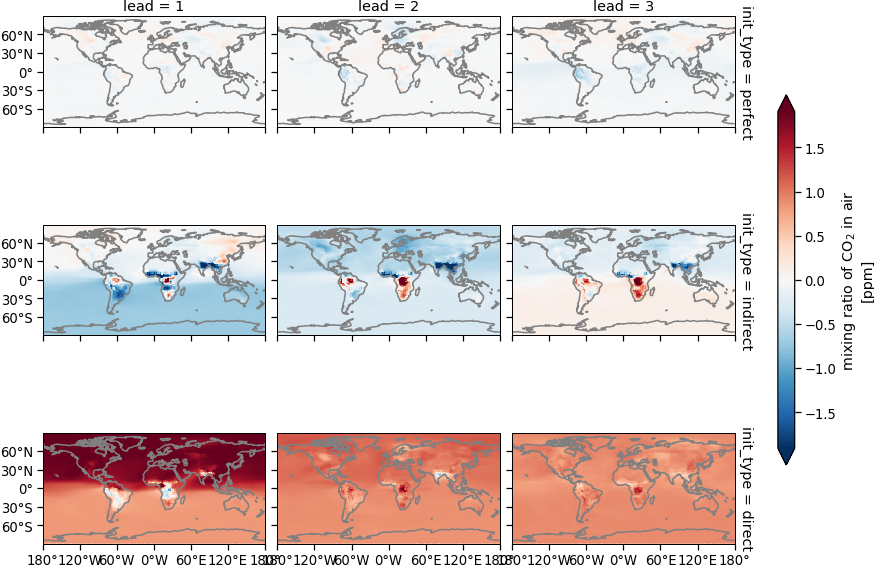

In [84]:
bias = pma.verify(metric="bias", **cp_kwargs)
bias[v].plot_map(col="lead", row="init_type", robust=True, aspect=1.3)

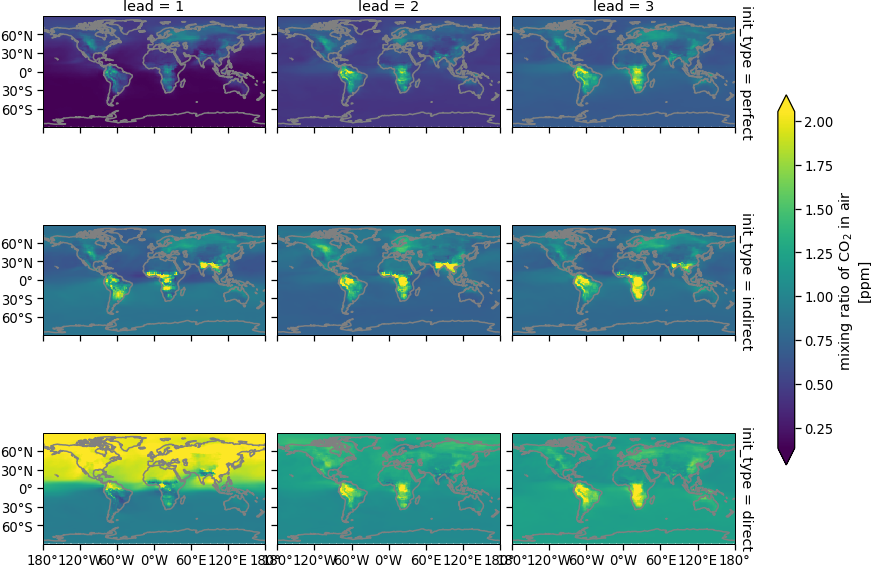

In [90]:
skill = pma.verify(metric=metric, **cp_kwargs)
skill[v].plot_map(col="lead", row="init_type", robust=True, aspect=1.3)

In [87]:
inits_debiased = debias(inits[[v]], bias)

In [88]:
pmad = PerfectModelEnsemble(inits_debiased[v]).map(yearmean, dim="lead")

In [93]:
skill_debiased = pmad.verify(metric=metric, **cp_kwargs)
# skill_debiased[v].plot_map(col="lead", row="init_type", aspect=1.3)

# spatial aggregation

In [46]:
name = "srex"
srex = getattr(regionmask.defined_regions, name)

In [47]:
name = "Longhurst"
gdf = geopandas.read_file(f"/home/mpim/m300524/.regionmask_data/{name}/{name}.shp")

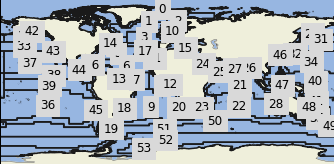

In [48]:
Longhurst = regionmask.from_geopandas(gdf, names="ProvDescr", abbrevs="ProvCode")
Longhurst.plot(add_land=True, add_ocean=True)

In [49]:
def to_regions(ds, region=None, agg_regions=None, mask=None):
    if "x" in ds.dims and "y" in ds.dims:
        stack_dims = "stacked_y_x"
        area = ocean_area
        if region is None and mask is None:
            region = ocean_regions
    elif "lat" in ds.dims and "lat" in ds.dims:
        stack_dims = "stacked_lat_lon"
        area = land_area
        if region is None and mask is None:
            region = srex_regions
    if mask is None and region is not None:
        mask = region.mask(ds)
    mask.name = "region"

    ds_sm = (ds * area).groupby(mask).sum(stack_dims)
    if isinstance(ds, xr.DataArray):
        ds = ds.to_dataset()
        was_dataset = False
    else:
        was_dataset = True

    if agg_regions is not None:
        print("found agg_regions:", agg_regions)

    ds_sm = ds_sm.map(
        reduce_unit_by_area_and_maybe_agg,
        agg_regions=agg_regions,
        mask=mask,
        area=area,
        stack_dims=stack_dims,
        keep_attrs=True,
    )
    if agg_regions == None and region is not None:
        ds_sm = set_regionmask_labels(ds_sm, region)

    if not was_dataset:
        ds_sm = ds_sm.to_array()
    return ds_sm

In [50]:
def reduce_unit_by_area_and_maybe_agg(
    da_sm, agg_regions=None, stack_dims=None, mask=None, area=None
):
    if "units" in da_sm.attrs:
        units = da_sm.attrs["units"]
        if "m-2" in units or "m-3" in units:
            da_sm.attrs["units"] = (
                da_sm.attrs["units"].replace("m-2", "").replace("m-3", "m-1")
            )
            da_sm = get_agg_regions(da_sm, agg_regions=agg_regions, how="sum")
        #if 'grid box' in units:
        #    da_sm = da_sm / (area.groupby(mask).sum(stack_dims))
        #    da_sm.attrs["units"] = da_sm.attrs["units"].replace('(grid box)','')
        else:
            assert da_sm.region.size > 0
            da_sm = da_sm / (area.groupby(mask).sum(stack_dims))
            assert da_sm.region.size > 0
            da_sm = get_agg_regions(da_sm, agg_regions=agg_regions, how="mean")
            assert da_sm.region.size > 0
    else: # if no units found spatial mean
        da_sm = da_sm / (area.groupby(mask).sum(stack_dims))
        da_sm = get_agg_regions(da_sm, agg_regions=agg_regions, how="mean")
    return da_sm


def set_regionmask_labels(ds, region):
    # extract the abbreviations and the names of the regions from regionmask
    abbrevs = region[ds.region.values].abbrevs
    names = region[ds.region.values].names
    ds.coords["abbrevs"] = ("region", abbrevs)
    ds.coords["names"] = ("region", names)
    return ds


agg_regions = {
    "Southern Ocean": [50, 51, 49],
    "Tropical Pacific": [39, 40, 38],
    "North Pacific": [30, 31, 29, 33],
    "North Atlantic": [2, 3, 1],
}


def get_agg_regions(ds_sm, agg_regions=agg_regions, how="mean"):
    """Aggregate regions based on `agg_regions` for analysis from Longhurst predefined regions."""
    if agg_regions is None:
        return ds_sm
    ds_agg_list = []
    for key, value in agg_regions.items():
        ds_agg_list.append(getattr(ds_sm.sel(region=value), how)("region"))
    ds_sm_agg = xr.concat(ds_agg_list, "region")
    ds_sm_agg["region"] = list(agg_regions.keys())
    return ds_sm_agg